# Dependencias

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from scikitplot.metrics import plot_roc

from varclushi import VarClusHi
from scipy import stats

import cufflinks as cf
import matplotlib.pyplot as plt
import seaborn as sns

cf.go_offline()
pd.set_option('display.max_columns',None)

# Lectura de datos

In [2]:
ruta='/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/diabetes.csv'
df=pd.read_csv(ruta)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# Definición de variables

In [4]:
df.insert(0,'id',df.index+1)

In [5]:
df.rename(columns={'Outcome':'y'},inplace=True)

In [6]:
um = ['id']
vart = ['y']
varc = [v for v in df.columns if v not in um and v not in vart]

# Análisis exploratorio

## Valores nulos

In [7]:
nulos = 1-df.describe().T[['count']]/len(df)
nulos

,count
id,0.0
Pregnancies,0.0
Glucose,0.0
BloodPressure,0.0
SkinThickness,0.0
Insulin,0.0
BMI,0.0
DiabetesPedigreeFunction,0.0
Age,0.0
y,0.0


## Varianza nula

In [8]:
vt = VarianceThreshold()
vt.fit(df[varc])

VarianceThreshold()

In [9]:
fuera = [a for a,b in zip(varc,vt.get_support()) if not b]
fuera

[]

## Multicolinealidad

In [10]:
vc = VarClusHi(df=df,feat_list=varc).varclus().rsquare.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
display(vc)
best = sorted(vc.groupby('Cluster').first()['Variable'])
best

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,Insulin,0.599575,0.114668,0.452288
1,0,Glucose,0.548782,0.049998,0.474966
2,0,DiabetesPedigreeFunction,0.299445,0.029821,0.722089
3,1,Pregnancies,0.772171,0.000729,0.227996
4,1,Age,0.772171,0.015617,0.231444
5,2,BMI,0.631529,0.074036,0.397932
6,2,SkinThickness,0.557513,0.110525,0.497470
7,2,BloodPressure,0.405669,0.046951,0.623610


['BMI', 'Insulin', 'Pregnancies']

## Selección de variables con mejor poder predictivo

In [11]:
sk = SelectKBest(k=len(varc))
sk.fit(df[varc],df[vart[0]])

SelectKBest(k=8)

In [12]:
pd.DataFrame(zip(varc,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                ascending=False).iplot(kind='bar',color='orange')

In [13]:
sk = SelectKBest(k=4)
sk.fit(df[varc],df[vart[0]])

SelectKBest(k=4)

In [14]:
best = [a for a,b in zip(varc,sk.get_support())if b]
best

['Pregnancies', 'Glucose', 'BMI', 'Age']

## Valores extremos

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>],
       [<AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'Age'}>]], dtype=object)

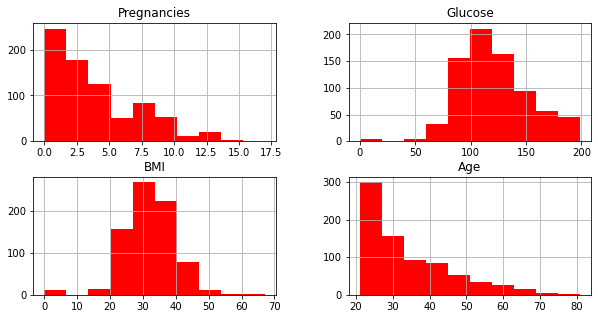

In [15]:
df[best].hist(figsize=(10,5),color='red')

In [16]:
for v,li,ls in df[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    df[f'ex_{v}']=((df[v]<li)|(df[v]>ls)).astype(int)
df['ex_'] = df.filter(like='ex_').max(axis=1)
df['ex_'].value_counts(1)

0    0.959635
1    0.040365
Name: ex_, dtype: float64

In [17]:
for v,li,ls in df[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    df.loc[df[v]<li,v]=np.nan
    df.loc[df[v]>ls,v]=np.nan

In [18]:
sm = SimpleImputer(strategy='median')
sm.fit(df[best])

SimpleImputer(strategy='median')

In [19]:
X = pd.DataFrame(sm.transform(df[best]),columns=best)
X[um+vart] = df[um+vart]

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>],
       [<AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'Age'}>]], dtype=object)

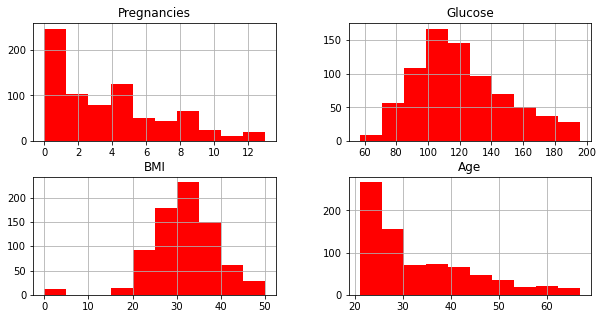

In [20]:
X[best].hist(figsize=(10,5),color='red')

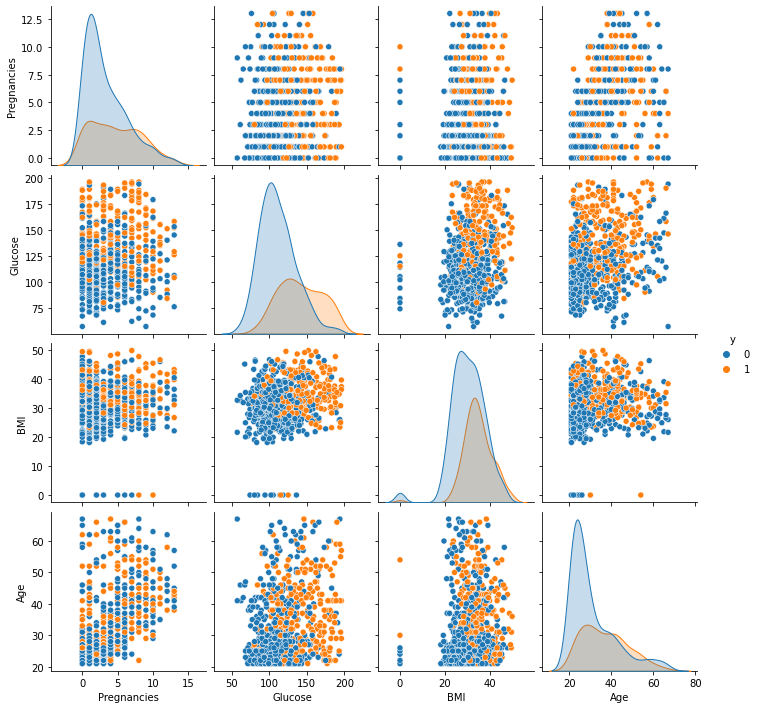

In [21]:
sns.pairplot(data=df[best+vart],hue=vart[0])

## Cambio de espacio $\mathcal{X}_{[0,1]}$

In [22]:
sc = MinMaxScaler()
sc.fit(X[best])

MinMaxScaler()

In [23]:
X01 = pd.DataFrame(sc.transform(X[best]),columns=best)
X01[um+vart] = X[um+vart]

# Partición de entrenamiento

In [24]:
St,Sv = train_test_split(X01,train_size=0.7)
St.reset_index(drop=True,inplace=True)
Sv.reset_index(drop=True,inplace=True)

# Aprendizaje

## Pasivo-Agresivo

In [25]:
hp = dict(max_iter=range(100,200),
         fit_intercept=[True,False],
         C = np.arange(0.1,2,0.01))
modelo = PassiveAggressiveClassifier()
grid = GridSearchCV(param_grid=hp,
                   cv=2,
                   scoring='accuracy',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [26]:
grid.fit(St[best],St[vart[0]])

Fitting 2 folds for each of 38000 candidates, totalling 76000 fits


GridSearchCV(cv=2, estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'C': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
       0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
       0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
       0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62,...
       1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52,
       1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63,
       1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74,
       1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85,
       1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96,
       1.97, 1.98, 1.99]),
                         'fit_intercept': [True, False],
                         'max_iter': range(100, 200)},
             scoring='accuracy', verbose=True)

In [27]:
grid.best_params_

{'C': 1.1799999999999995, 'fit_intercept': True, 'max_iter': 147}

In [28]:
modelo = grid.best_estimator_
modelo

PassiveAggressiveClassifier(C=1.1799999999999995, max_iter=147)

In [29]:
modelo.fit(X01[best],X01[vart[0]])

PassiveAggressiveClassifier(C=1.1799999999999995, max_iter=147)

### Validación del modelo

In [30]:
St['y^'] = modelo.predict(St[best])
Sv['y^'] = modelo.predict(Sv[best])

In [31]:
print(accuracy_score(y_pred=St['y^'],y_true=St[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.5772811918063314
0.6277056277056277


In [32]:
print(confusion_matrix(y_pred=St['y^'],y_true=St[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[130 221]
 [  6 180]]
[[64 85]
 [ 1 81]]


## Análisis Discriminante

In [33]:
modelo = LinearDiscriminantAnalysis()
modelo.fit(St[best],St[vart[0]])

LinearDiscriminantAnalysis()

### Validación del modelo

In [34]:
St['y^'] = modelo.predict(St[best])
Sv['y^'] = modelo.predict(Sv[best])

St['proba'] = modelo.predict_proba(St[best])[:,1]
Sv['proba'] = modelo.predict_proba(Sv[best])[:,1]

In [35]:
print(accuracy_score(y_pred=St['y^'],y_true=St[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.74487895716946
0.7619047619047619


In [36]:
print(confusion_matrix(y_pred=St['y^'],y_true=St[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[306  45]
 [ 92  94]]
[[130  19]
 [ 36  46]]


In [37]:
print(roc_auc_score(y_score=St['proba'],y_true=St[vart[0]]))
print(roc_auc_score(y_score=Sv['proba'],y_true=Sv[vart[0]]))

0.8234384094599149
0.8323784580127681


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

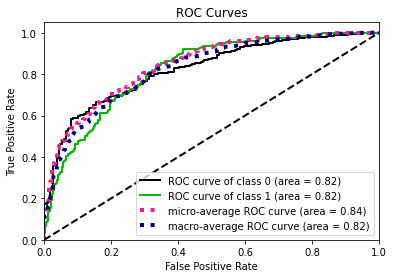

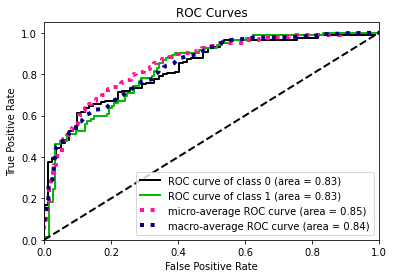

In [38]:
plot_roc(y_probas=modelo.predict_proba(St[best]),y_true=St[vart[0]])
plot_roc(y_probas=modelo.predict_proba(Sv[best]),y_true=Sv[vart[0]])

<AxesSubplot:ylabel='Density'>

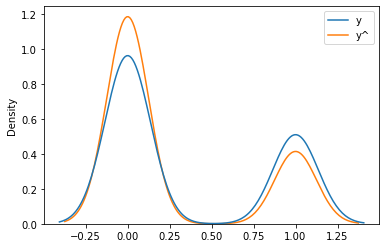

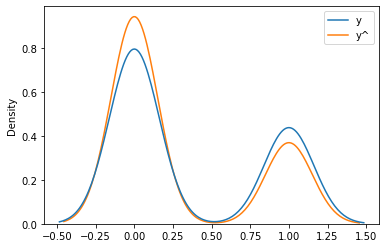

In [39]:
plt.figure()
sns.kdeplot(data=St[vart+['y^']])
plt.figure()
sns.kdeplot(data=Sv[vart+['y^']])

## SVM

In [40]:
hp = dict(C=np.arange(0.1,4,0.1),
          kernel=['linear','poly','sigmoid','rbf'],
          degree=range(2,4),
          probability=[True])
modelo = SVC()
grid = GridSearchCV(param_grid=hp,
                   cv=4,
                   scoring='accuracy',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [41]:
grid.fit(St[best],St[vart[0]])

Fitting 4 folds for each of 312 candidates, totalling 1248 fits


GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9]),
                         'degree': range(2, 4),
                         'kernel': ['linear', 'poly', 'sigmoid', 'rbf'],
                         'probability': [True]},
             scoring='accuracy', verbose=True)

In [42]:
grid.best_params_

{'C': 3.8000000000000003, 'degree': 2, 'kernel': 'poly', 'probability': True}

In [43]:
modelo = grid.best_estimator_
modelo

SVC(C=3.8000000000000003, degree=2, kernel='poly', probability=True)

In [44]:
modelo.fit(St[best],St[vart[0]])

SVC(C=3.8000000000000003, degree=2, kernel='poly', probability=True)

### Validación del modelo

In [45]:
St['y^'] = modelo.predict(St[best])
Sv['y^'] = modelo.predict(Sv[best])

St['proba'] = modelo.predict_proba(St[best])[:,1]
Sv['proba'] = modelo.predict_proba(Sv[best])[:,1]

In [46]:
print(accuracy_score(y_pred=St['y^'],y_true=St[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.7616387337057728
0.7792207792207793


In [47]:
print(confusion_matrix(y_pred=St['y^'],y_true=St[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[315  36]
 [ 92  94]]
[[136  13]
 [ 38  44]]


In [48]:
print(roc_auc_score(y_score=St['proba'],y_true=St[vart[0]]))
print(roc_auc_score(y_score=Sv['proba'],y_true=Sv[vart[0]]))

0.8295652973072327
0.8554591586184319


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

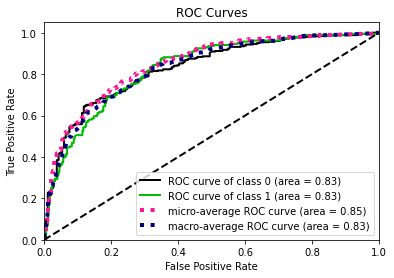

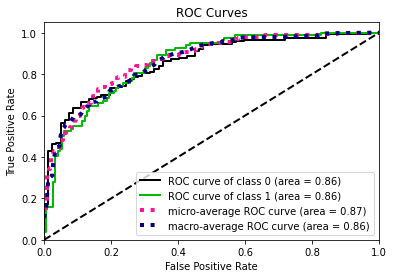

In [49]:
plot_roc(y_probas=modelo.predict_proba(St[best]),y_true=St[vart[0]])
plot_roc(y_probas=modelo.predict_proba(Sv[best]),y_true=Sv[vart[0]])

<AxesSubplot:ylabel='Density'>

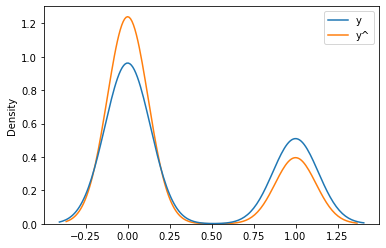

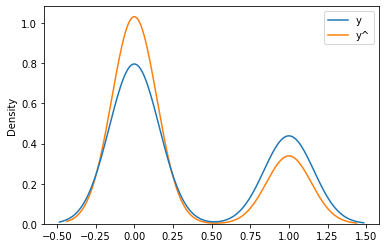

In [50]:
plt.figure()
sns.kdeplot(data=St[vart+['y^']],warn_singular=False)
plt.figure()
sns.kdeplot(data=Sv[vart+['y^']],warn_singular=False)

## LR

In [51]:
modelo = LogisticRegression(n_jobs=-1)
modelo.fit(St[best],St[vart[0]])

LogisticRegression(n_jobs=-1)

### Validaciópn del modelo

In [52]:
St['y^'] = modelo.predict(St[best])
Sv['y^'] = modelo.predict(Sv[best])

St['proba'] = modelo.predict_proba(St[best])[:,1]
Sv['proba'] = modelo.predict_proba(Sv[best])[:,1]

In [53]:
print(accuracy_score(y_pred=St['y^'],y_true=St[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.74487895716946
0.7662337662337663


In [54]:
print(confusion_matrix(y_pred=St['y^'],y_true=St[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[312  39]
 [ 98  88]]
[[135  14]
 [ 40  42]]


In [55]:
print(roc_auc_score(y_score=St['proba'],y_true=St[vart[0]]))
print(roc_auc_score(y_score=Sv['proba'],y_true=Sv[vart[0]]))

0.8238979260484637
0.8306596824357505


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

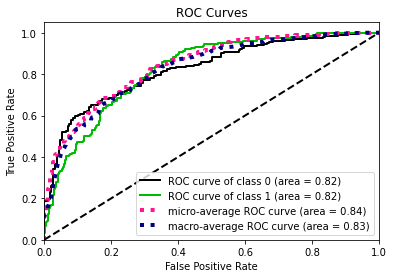

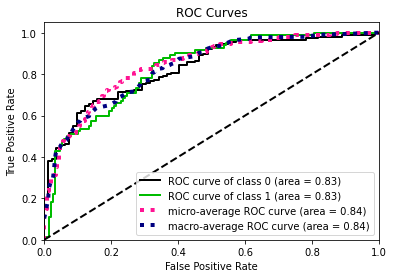

In [56]:
plot_roc(y_probas=modelo.predict_proba(St[best]),y_true=St[vart[0]])
plot_roc(y_probas=modelo.predict_proba(Sv[best]),y_true=Sv[vart[0]])

<AxesSubplot:ylabel='Density'>

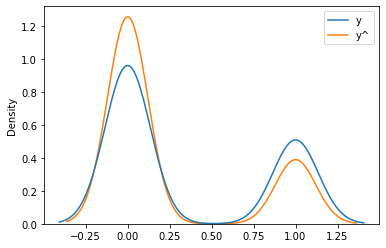

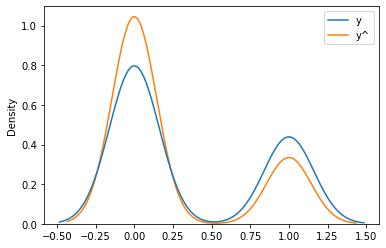

In [57]:
plt.figure()
sns.kdeplot(data=St[vart+['y^']],warn_singular=False)
plt.figure()
sns.kdeplot(data=Sv[vart+['y^']],warn_singular=False)

## Red Neuronal

In [58]:
hp = dict(hidden_layer_sizes=[(a,b,c) for a in range(2,3) for b in range(2,7) for c in range(2,3)],
         activation=['identity','logistic','tanh','relu'],
         solver=['sgd'],
         alpha=np.arange(0.0001,0.001,0.0001),
         learning_rate=['constant','invscaling','adaptive'],
         max_iter=[10000])
modelo = MLPClassifier()
grid = GridSearchCV(param_grid=hp,
                   cv=2,
                   scoring='roc_auc',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [59]:
grid.fit(St[best],St[vart[0]])

Fitting 2 folds for each of 540 candidates, totalling 1080 fits


GridSearchCV(cv=2, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'hidden_layer_sizes': [(2, 2, 2), (2, 3, 2), (2, 4, 2),
                                                (2, 5, 2), (2, 6, 2)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [10000], 'solver': ['sgd']},
             scoring='roc_auc', verbose=True)

In [60]:
grid.best_params_

{'activation': 'identity',
 'alpha': 0.0002,
 'hidden_layer_sizes': (2, 6, 2),
 'learning_rate': 'adaptive',
 'max_iter': 10000,
 'solver': 'sgd'}

In [61]:
modelo = grid.best_estimator_
modelo

MLPClassifier(activation='identity', alpha=0.0002, hidden_layer_sizes=(2, 6, 2),
              learning_rate='adaptive', max_iter=10000, solver='sgd')

In [62]:
modelo.fit(St[best],St[vart[0]])

MLPClassifier(activation='identity', alpha=0.0002, hidden_layer_sizes=(2, 6, 2),
              learning_rate='adaptive', max_iter=10000, solver='sgd')

### Validación del modelo

In [63]:
St['y^'] = modelo.predict(St[best])
Sv['y^'] = modelo.predict(Sv[best])

St['proba'] = modelo.predict_proba(St[best])[:,1]
Sv['proba'] = modelo.predict_proba(Sv[best])[:,1]

In [64]:
print(accuracy_score(y_pred=St['y^'],y_true=St[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.6536312849162011
0.645021645021645


In [65]:
print(confusion_matrix(y_pred=St['y^'],y_true=St[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[351   0]
 [186   0]]
[[149   0]
 [ 82   0]]


In [66]:
print(roc_auc_score(y_score=St['proba'],y_true=St[vart[0]]))
print(roc_auc_score(y_score=Sv['proba'],y_true=Sv[vart[0]]))

0.5725576693318628
0.6525617940743167


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

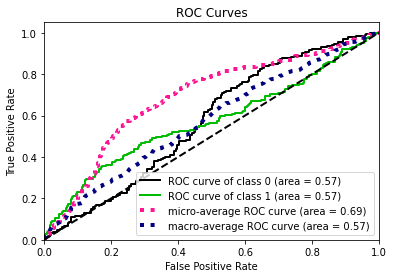

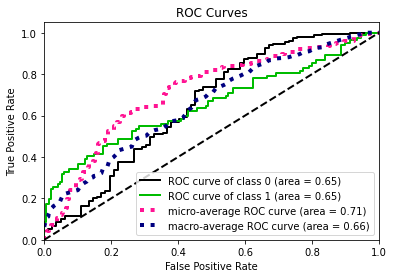

In [67]:
plot_roc(y_probas=modelo.predict_proba(St[best]),y_true=St[vart[0]])
plot_roc(y_probas=modelo.predict_proba(Sv[best]),y_true=Sv[vart[0]])

<AxesSubplot:ylabel='Density'>

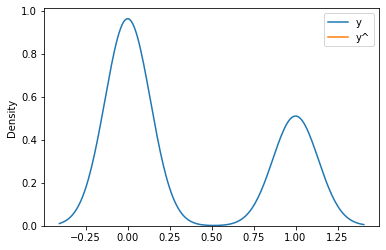

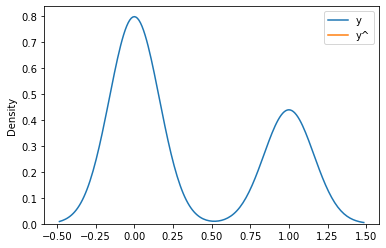

In [68]:
plt.figure()
sns.kdeplot(data=St[vart+['y^']],warn_singular=False)
plt.figure()
sns.kdeplot(data=Sv[vart+['y^']],warn_singular=False)